# Opinion dynamics over discourse sheaves

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from scipy.linalg import null_space, expm
from scipy.integrate import solve_ivp

from builder import SheafBuilder
from models import SheafDynamic
from visualization import opinion_trajectory_plot, simplicial_opinion_trajectory_plot

from itertools import combinations

## Constant sheaves with stalk equal to $\mathbb{R}^n$ on each vertex and node

### Opinion diffusion via Laplacian heat equation 

In [2]:
sheaf = SheafBuilder(7, 5, constant = True, seed = None)

x0 = sheaf.initial_state()
x_null = sheaf.null_space_projector(x0)

dynamic = SheafDynamic(
    sheaf.L_f, 
    sheaf.B, 
    0.1, 
    0.5, 
    sheaf.edges, 
    sheaf.V, 
    sheaf.d, 
    x0)

In [17]:
sheaf.edges

[(0, 2), (0, 5), (1, 3), (1, 4), (1, 6), (2, 3), (2, 5), (3, 6)]

In [18]:
trajectories_1 = dynamic.privateOpinionDynamicSolver()

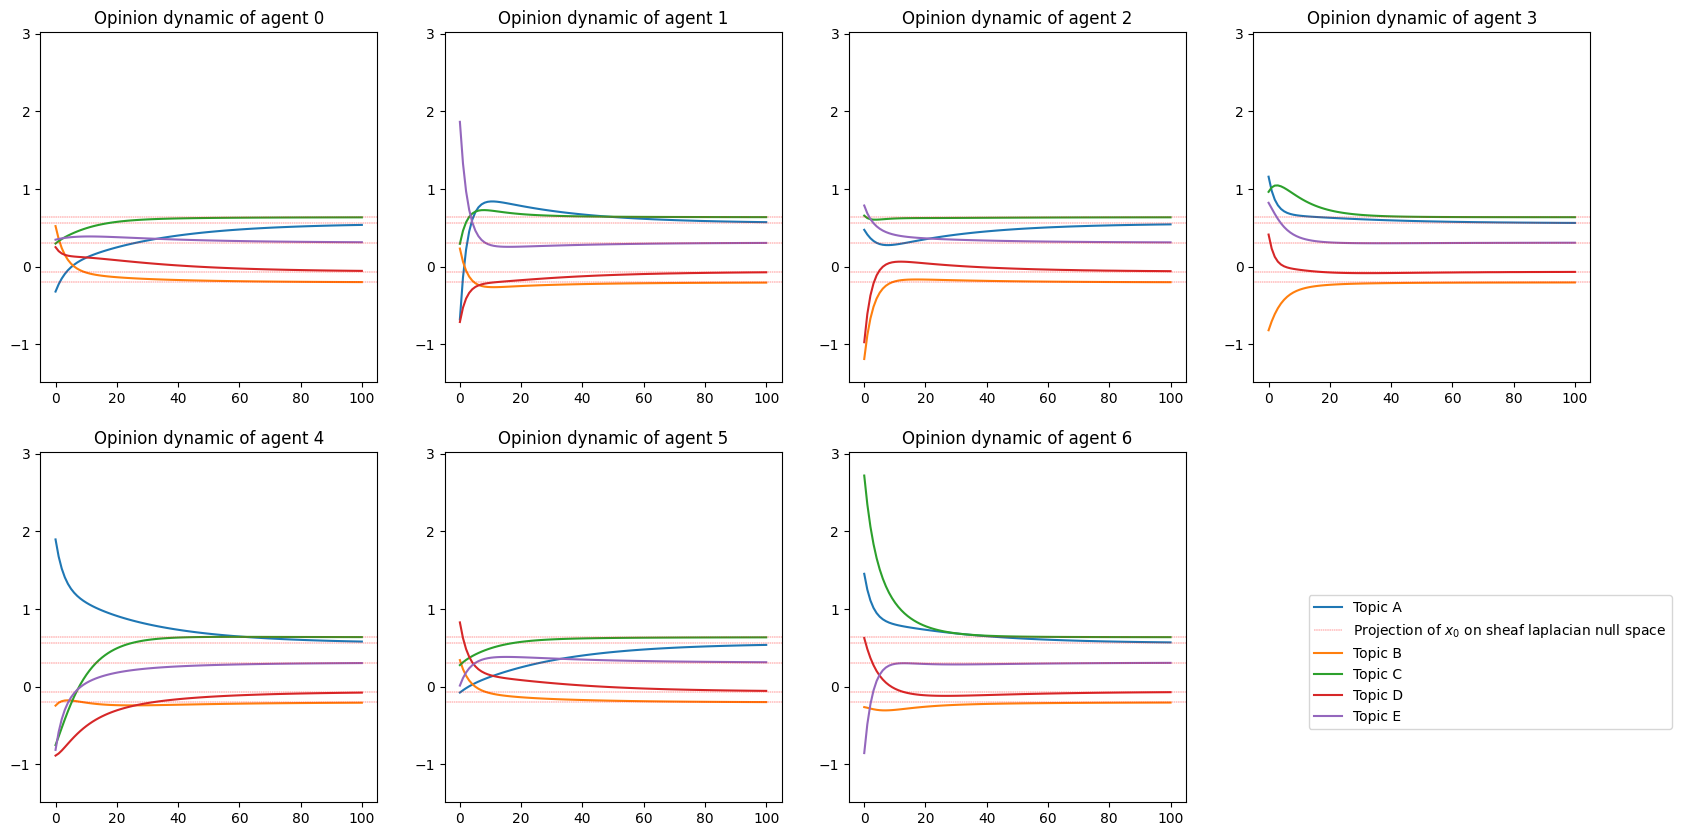

In [19]:
opinion_trajectory_plot(trajectories_1, dynamic.time_points, sheaf.d, range(sheaf.V), x_null)

### Modeling stubborn agents requires just restriction over the dynamics

In [20]:
U = np.random.choice(7, 3, replace = False)
sheaf = SheafBuilder(7, 5, constant = True, stubborn = U, seed = None)

x0 = sheaf.initial_state()
x_null = sheaf.null_space_projector(x0)

dynamic = SheafDynamic(
    sheaf.L_f, 
    sheaf.B, 
    0.1, 
    0.5, 
    sheaf.edges, 
    sheaf.V, 
    sheaf.d, 
    x0,
    U = U)

In [21]:
trajectories_2 = dynamic.privateOpinionDynamicSolver()

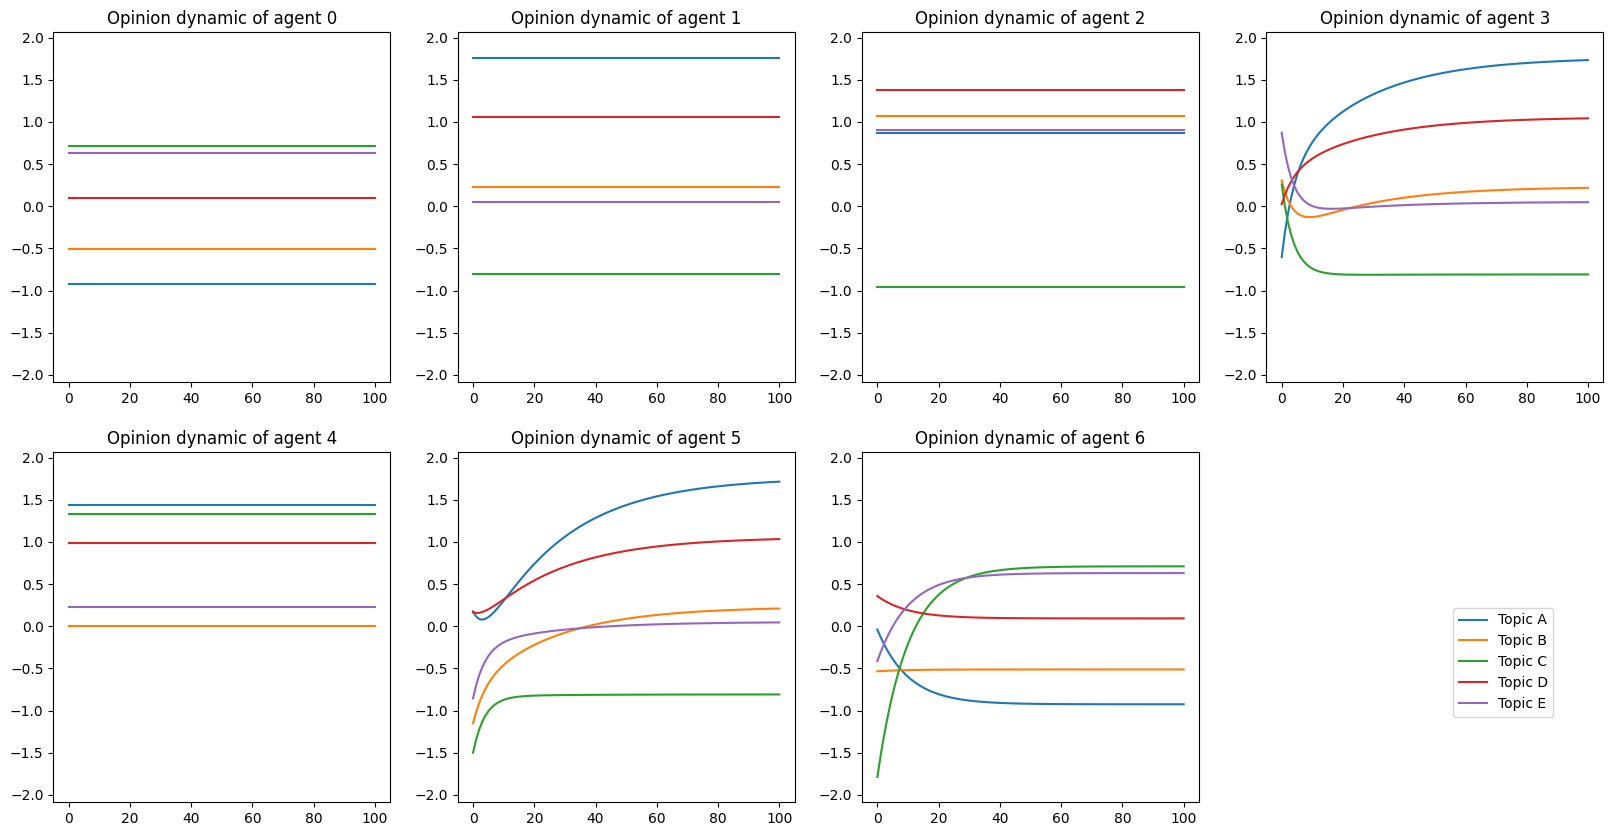

In [22]:
opinion_trajectory_plot(trajectories_2, dynamic.time_points, sheaf.d, range(sheaf.V),)

### Beyond stubborness: forcing opinions 

In [8]:
U = np.random.choice(7, 1, replace = False)
Y = [agent for agent in range(7) if agent not in U]

sheaf = SheafBuilder(7, 4, constant = True, stubborn = U, control = Y)

x0 = sheaf.initial_state()
x_null = sheaf.null_space_projector(x0)

dynamic = SheafDynamic(
    sheaf.L_f, 
    sheaf.B, 
    0.1, 
    0.5, 
    sheaf.edges, 
    sheaf.V, 
    sheaf.d, 
    x0,
    U = U, 
    Y = Y)

In [9]:
_, trajectories_3 = dynamic.forcingOpinionDynamicSolver()

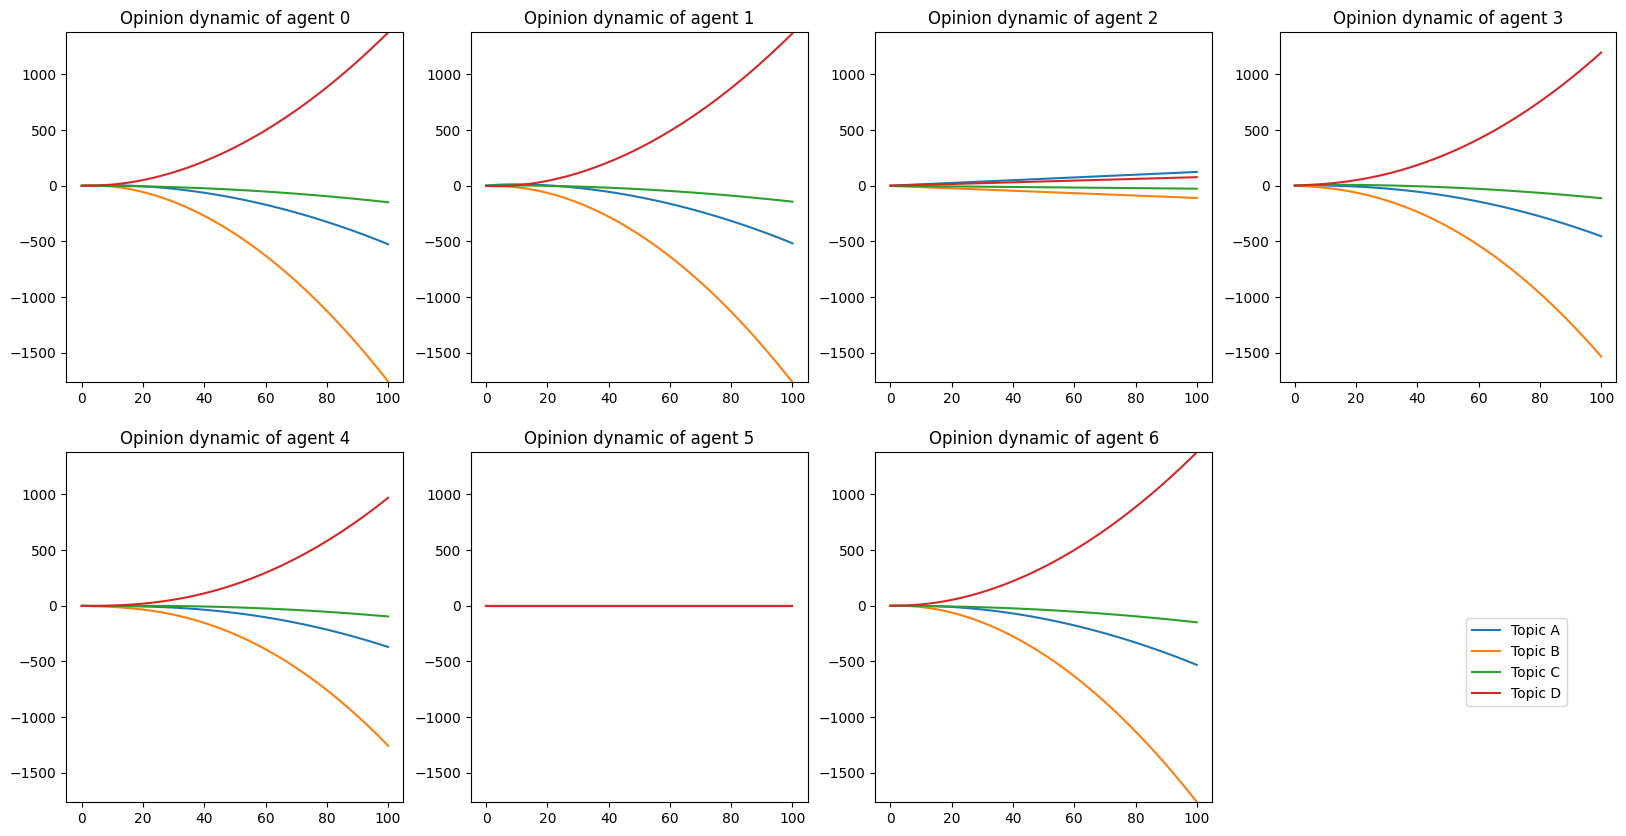

In [10]:
opinion_trajectory_plot(trajectories_3, dynamic.time_points, sheaf.d, range(sheaf.V),)

### Weighted reluctance: augmenting the network with stubborn parents 

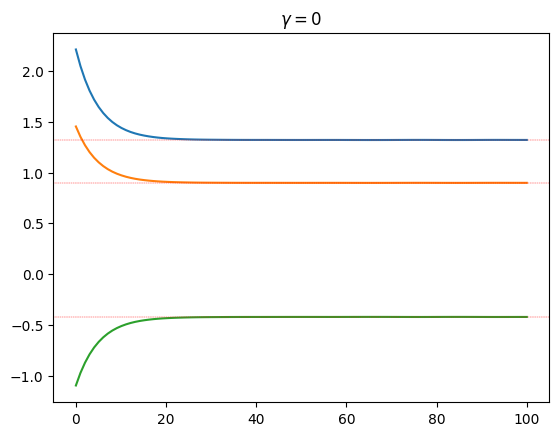

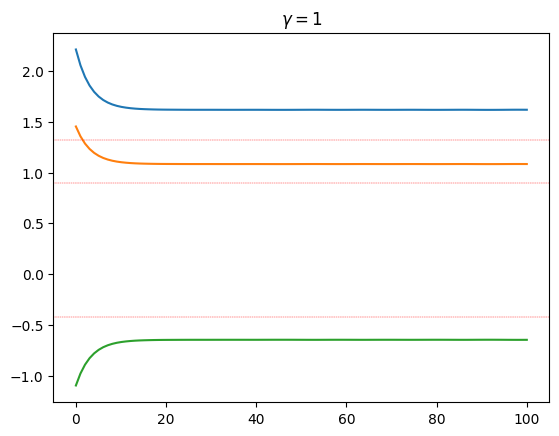

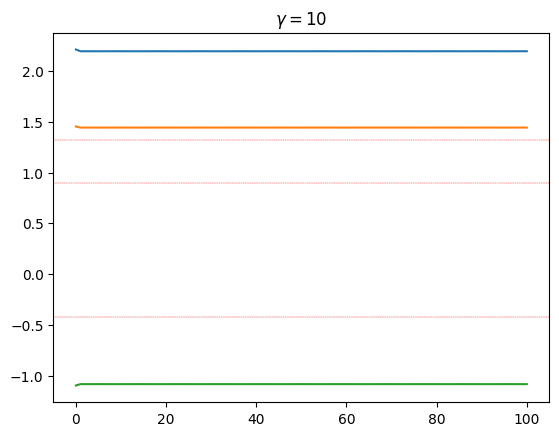

In [11]:
for gamma in [0, 1, 10]:
    sheaf = SheafBuilder(4, 3, seed = 4200)
    sheaf.augmentedConstantSheaf(gamma = gamma)

    x0 = sheaf.augmented_initial_state()
    x_null = sheaf.null_space_projector(x0)

    dynamic = SheafDynamic(
        sheaf.L_f, 
        sheaf.B, 
        0.1, 
        0.5, 
        sheaf.edges, 
        sheaf.V, 
        sheaf.d, 
        x0,
        U = sheaf.nodes[int(len(sheaf.nodes)/2):])

    trajectories_4 = dynamic.privateOpinionDynamicSolver()

    plt.plot(dynamic.time_points, trajectories_4[:, 0:3])
    for i in range(3):
        plt.axhline(y=x_null[i], 
                    color='r', 
                    linestyle='--', 
                    linewidth=0.3, 
                    label=f'x_null[{i}]')
    plt.title(f'$\gamma = {gamma}$')

    plt.show()
    #opinion_trajectory_plot(trajectories_4, dynamic.time_points, sheaf.d, range(sheaf.V), x_null, legend=False)

### Expression diffusion for "learning to lie" dynamics

In [15]:
sheaf = SheafBuilder(7, 3)
x0 = sheaf.initial_state()

In [16]:
dynamic = SheafDynamic(
    sheaf.L_f, 
    sheaf.B, 
    0.1, 
    0.5, 
    int(len(sheaf.edges)), 
    sheaf.V, 
    sheaf.d, 
    x0)

In [17]:
trajectories_5, disagreement = dynamic.expressionDynamicSolver()

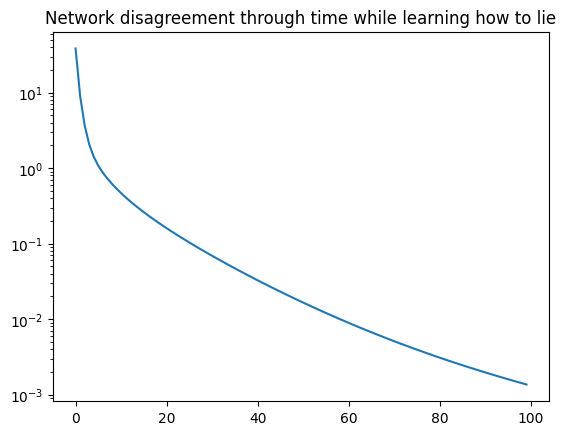

In [18]:
plt.plot(disagreement)
plt.title('Network disagreement through time while learning how to lie')
plt.yscale('log')

_______________

# Simplicial Complex Dynamics

In [2]:
class SimplicialSheafBuilder:
    
    def __init__(
            self, 
            V, 
            d,
            ntriangles = 'Full',
            cutoff = 0.5,
            seed = 42
            ):

        self.V = V
        self.nodes = list(range(self.V))
        self.d = d
        self.ntriangles = ntriangles
        self.cutoff = cutoff

        # Seed for reproducibility
        self.seed = seed

        # Graph builder
        self.randomGraph()

        # Simplicial builder
        self.random2SC()

        # Sheaf builder
        self.SCSbuilder()

    def randomGraph(
            self
        ):

        if self.seed is not None:
            np.random.seed(self.seed)

        self.edges = []

        points = np.random.rand(self.V, 2)

        self.A = np.zeros((self.V,self.V))

        for i in range(self.V):
            for j in range(i + 1, self.V):
                
                self.A[i,j] = np.linalg.norm(points[i,:] - points[j,:]) <= self.cutoff
                self.A[j,i] = np.linalg.norm(points[i,:] - points[j,:]) <= self.cutoff

                if self.A[i,j] == 1:
                    self.edges.append((i,j))

    def triangleFinder(self):
        all_cliques = list(combinations(range(self.V), 3)) 
        true_cliques = []
        for clique in all_cliques:
            u, v, w = clique[0], clique[1], clique[2]
            A = ((u,v) in self.edges or (v,u) in self.edges)
            B = ((v,w) in self.edges or (w,v) in self.edges)
            C = ((w,u) in self.edges or (u,w) in self.edges)

            if A and B and C:
                true_cliques.append((u,v,w))

        return true_cliques
    
    def random2SC(self):
        if self.seed is not None:
            np.random.seed(self.seed)

        all_triangles = self.triangleFinder()
        if self.ntriangles == 'Full':
            self.triangles = all_triangles
        else:
            T = [all_triangles[i] for i in np.random.choice(len(all_triangles), self.ntriangles, replace=False).tolist()]
            self.triangles = T
    
    def SCSbuilder(
            self
        ):

        # Coboundary maps

        self.B0 = np.zeros((self.d*self.V, self.d*len(self.edges)))               
        self.B0_graph = np.zeros((self.V, len(self.edges))) 

        self.B1 = np.zeros((self.d*len(self.edges), self.d*len(self.triangles)))
        
        edges_idxs = {}

        for i, edge in enumerate(self.edges):

            u = edge[0] 
            v = edge[1] 

            self.B0[u*self.d:(u+1)*self.d, i*self.d:(i+1)*self.d] = - np.eye(self.d)      
            self.B0[v*self.d:(v+1)*self.d, i*self.d:(i+1)*self.d] = np.eye(self.d)

            self.B0_graph[u, i] = -1
            self.B0_graph[v, i] = 1

            edges_idxs[edge] = i

        for j, triangle in enumerate(self.triangles):
                e1 = (triangle[0], triangle[1])
                e2 = (triangle[1], triangle[2])
                e3 = (triangle[0], triangle[2])

                self.B1[self.d*edges_idxs[e1]:self.d*(edges_idxs[e1]+1), j*self.d:(j+1)*self.d] = np.eye(self.d) 
                self.B1[self.d*edges_idxs[e2]:self.d*(edges_idxs[e2]+1), j*self.d:(j+1)*self.d] = - np.eye(self.d)
                self.B1[self.d*edges_idxs[e3]:self.d*(edges_idxs[e3]+1), j*self.d:(j+1)*self.d] = - np.eye(self.d)

        self.L0 = self.B0 @ self.B0.T
        self.L1 = self.B0.T @ self.B0 + self.B1 @ self.B1.T

    def initial_vertex_flow(self): 
        if self.seed is not None:
            np.random.seed(self.seed)
            
        return np.random.randn(self.V*self.d)
    
    def initial_edge_flow(self):
        if self.seed is not None:
            np.random.seed(self.seed)

        return np.random.randn(len(self.edges)*self.d)

In [3]:
class SimplicialSheafDynamic:
    def __init__(
            self, 
            SC, 
            alpha, 
            beta,
            T = 100,
            timespan = 100,
        ):

        # Simplicial sheaf
        self.SC = SC
        self.PB_0 = (self.SC.B0 != 0).astype('int32')
        self.PB_1 = (self.SC.B1.T != 0).astype('int32')

        # Parameter in the dynamics
        self.alpha = alpha
        self.beta = beta
        
        # Considered timewindow
        self.T = T
        self.timespan = timespan 
        self.time_points = np.linspace(0,self. T, self.timespan)

    ##############################
    #### METHODS FOR DYNAMICS ####
    ##############################

    def edgeFlowDynamic(self, t, xi):
        return -self.alpha * self.SC.L1 @ xi   
     
    def solver(
            self
        ):

        xi0 = self.SC.initial_edge_flow()

        solution = solve_ivp(
            self.edgeFlowDynamic, 
            [0, self.T], 
            xi0, 
            t_eval=self.time_points, 
            args=(),
            method='RK45'
            )

        return solution.y.T
    
    def expression_dynamic(self, t, B_flatten, xi0):

        B0 = B_flatten[:self.SC.V*self.SC.d + len(self.SC.edges)*self.SC.d].reshape(self.SC.V * self.SC.d, len(self.SC.edges) * self.SC.d)
        B1 = B_flatten[self.SC.V*self.SC.d + len(self.SC.edges)*self.SC.d:].reshape(len(self.SC.edges)*self.SC.d, len(self.SC.triangles)*self.SC.d)
        
        dtdB0 = (-self.beta * self.PB_0 * (B0 @ np.outer(xi0, xi0))).flatten()
        dtdB1 = (-self.beta * self.PB_1 * (B1.T @ np.outer(xi0, xi0))).flatten()

        return np.concatenate([dtdB0, dtdB1])
    
    def expressionDynamicSolver(
            self
        ):

        xi0 = self.SC.initial_edge_flow()
        solution = solve_ivp(
            self.expression_dynamic, 
            [0, self.T], 
            np.concatenate([self.SC.B0.flatten, self.SC.B1.flatten]), 
            t_eval=self.time_points, 
            args=(xi0),
            method='RK45'
            )
        
        B_hat = solution.y[:,-1].reshape(self.E*self.d, self.V*self.d)
        
        # Tracker of the disagreement 
        Bs = solution.y.T.reshape(self.time_points.shape[0], self.E*self.d, self.V*self.d)
        disagreement = self.x0.T @ (Bs.transpose(0,2,1) @ Bs.transpose(0,1,2)) @ self.x0

        return B_hat, disagreement

In [19]:
SC = SimplicialSheafBuilder(11, 3, 3, seed = 420)
dynamic = SimplicialSheafDynamic(SC, 0.1, 0.1)
xi_traj = dynamic.solver()

null = null_space(SC.L1)
proj = null @ null.T

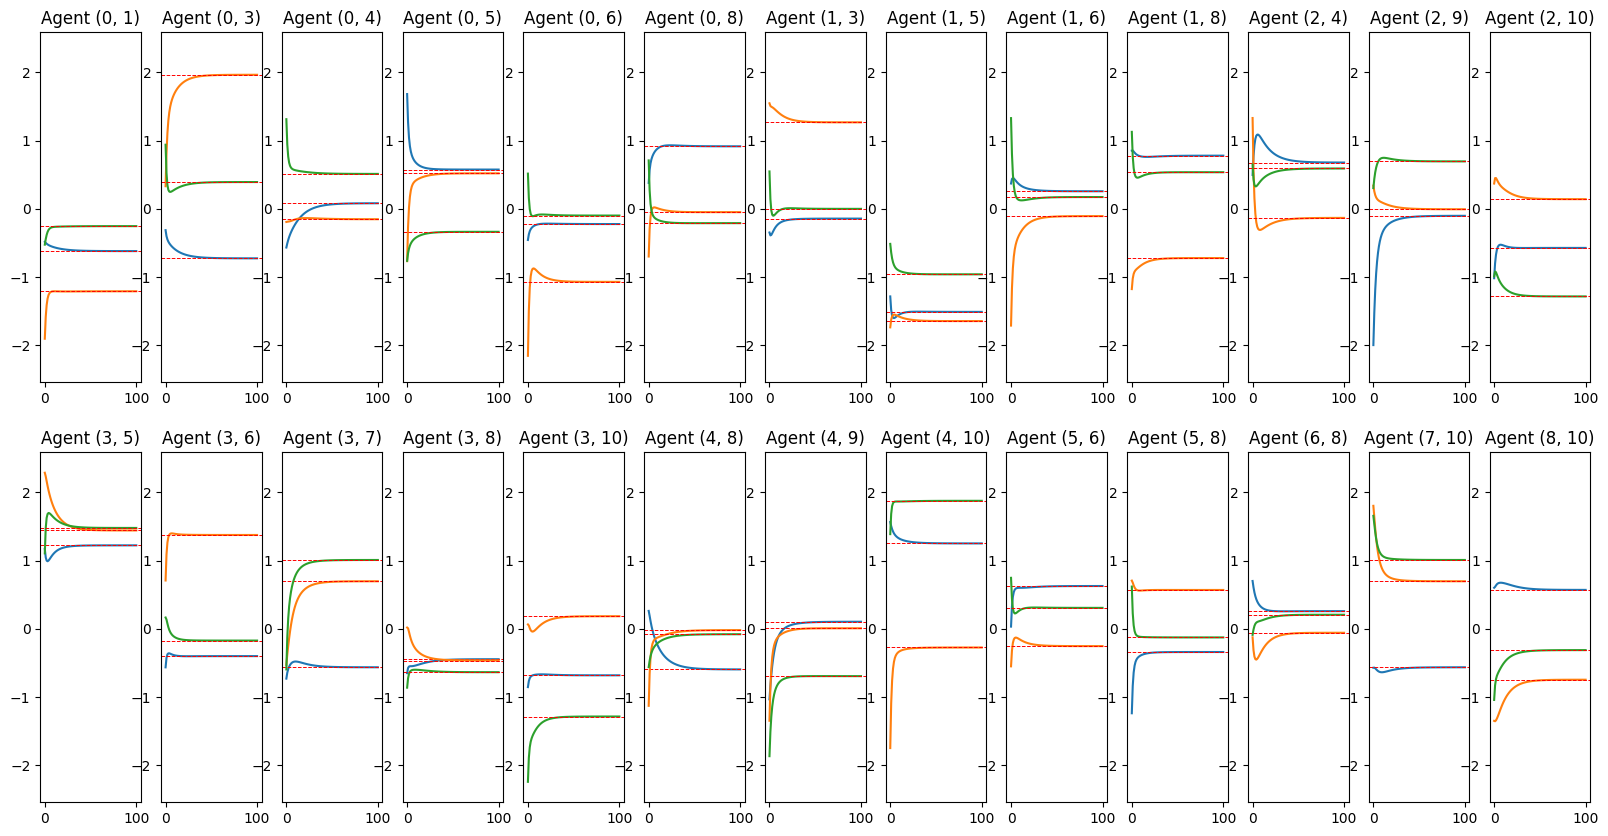

In [20]:
simplicial_opinion_trajectory_plot(xi_traj, dynamic.time_points, SC.d, SC.edges, proj @ xi_traj[0,:])

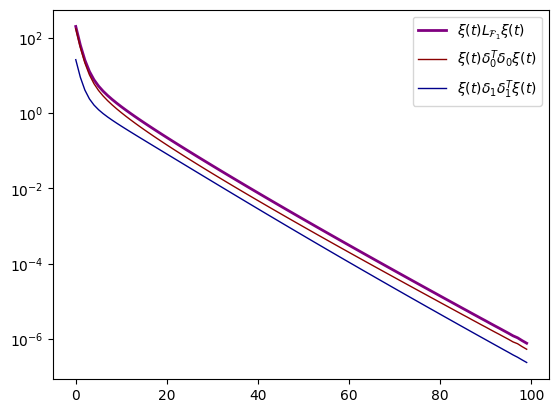

In [37]:
results_1 = np.einsum('ij,jk,ik->i', xi_traj, SC.L1, xi_traj)
results_2 = np.einsum('ij,jk,ik->i', xi_traj, SC.B0.T @ SC.B0, xi_traj)
results_3 = np.einsum('ij,jk,ik->i', xi_traj, SC.B1 @ SC.B1.T, xi_traj)

plt.plot(results_1, label = r'$\xi(t) L_{\mathcal{F}_1} \xi(t)$', linewidth = 2, color = 'purple')
plt.plot(results_2, label = r'$\xi(t) \delta_0^T\delta_0 \xi(t)$', linewidth = 1, color = 'darkred')
plt.plot(results_3, label = r'$\xi(t) \delta_1\delta_1^T \xi(t)$', linewidth = 1, color = 'darkblue')
plt.yscale('log')
plt.legend()
plt.show()

In [26]:
SC.triangles

[(2, 4, 10), (0, 5, 8), (1, 3, 6)]